In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics
import os
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler



### Reading Training data

In [2]:
df1=pd.read_csv("./processed/training/engaged.csv")
df2=pd.read_csv("./processed/training/notEngaged.csv")
dff=pd.read_csv("./TopFeatures.csv")

In [3]:
dft=pd.concat([df1,df2])

In [4]:
feat=dff.to_numpy()
feat=feat.reshape(-1)

In [5]:
print(feat)

[' AU12_c' ' AU04_c' ' AU04_r' ' AU12_r' ' AU05_c' ' AU14_c' ' AU06_c'
 ' AU10_c' ' AU14_r' ' p_2' ' AU06_r' ' p_8' ' AU07_r' ' AU10_r' ' p_0'
 ' p_10' ' p_7' ' p_6' ' AU01_r' ' p_23' ' p_12' ' AU26_r' ' AU25_r'
 ' p_5' ' AU45_r' ' p_20' ' AU09_r' ' AU17_r' ' p_24' ' p_9' ' AU05_r'
 ' p_11' ' p_18' ' AU15_c' ' p_16' ' AU23_r' ' p_27' ' p_3' ' p_13'
 ' p_26' ' AU02_r' ' p_15' ' p_19' ' p_21' ' AU20_r' ' AU15_r' ' p_30'
 ' p_1' ' gaze_1_z' ' p_31']


In [6]:
y_train=dft["Result"]
x_train=dft.drop("Result",axis=1)
x_train=x_train[feat]

In [7]:
# compute required values
scaler = StandardScaler()
model = scaler.fit(x_train)
x_train = model.transform(x_train)

In [8]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt



### Splitting training and test at ratio 75% to 25%

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_train,y_train,test_size=0.25)

### Initialize model with optimum parameters

In [10]:
model = RandomForestClassifier(class_weight="balanced")

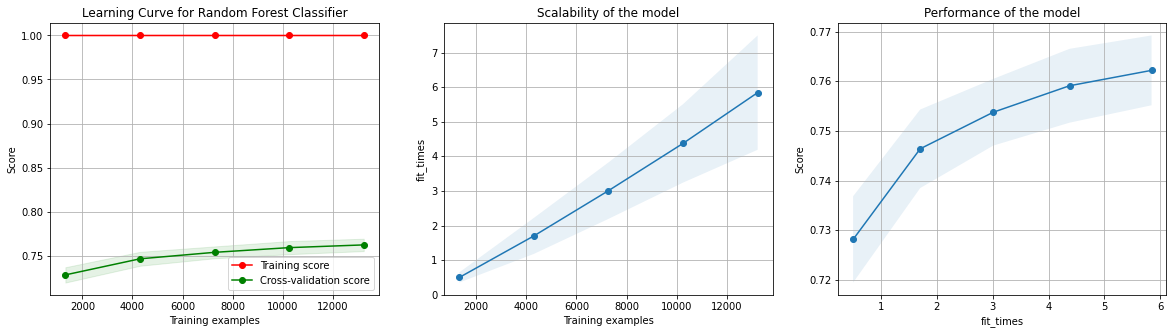

In [11]:
#fig, axes = plt.subplots(3, 1, figsize=(10, 15))


# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)


title = "Learning Curve for Random Forest Classifier"
estimator = model
plot_learning_curve(estimator, title, X_train, Y_train,
                    cv=cv, n_jobs=4)
plt.show()
plt.close()
    

### Training of the given model with the training data

In [12]:
model = model.fit(X_train, Y_train)

In [13]:
target_names = ['Not Engaged','Engaged']
claf_report=classification_report(Y_test,model.predict(X_test),target_names=target_names,output_dict=True)
print(claf_report)

{'Not Engaged': {'precision': 0.7201779215527699, 'recall': 0.7308165777595405, 'f1-score': 0.7254582484725052, 'support': 2437}, 'Engaged': {'precision': 0.7842814863531733, 'recall': 0.775105622359441, 'f1-score': 0.7796665576985943, 'support': 3077}, 'accuracy': 0.755531374682626, 'macro avg': {'precision': 0.7522297039529716, 'recall': 0.7529611000594907, 'f1-score': 0.7525624030855498, 'support': 5514}, 'weighted avg': {'precision': 0.7559498963244132, 'recall': 0.755531374682626, 'f1-score': 0.7557083332546373, 'support': 5514}}


In [14]:
helix=pd.read_csv("./TopFeatures.csv")
h2=pd.read_csv("./heatMaps.csv")
helix['value']=h2
#print(helix)
helix.to_csv("Finalmaps.csv",index=None,header=None)

g1=pd.read_csv("./Finalmaps.csv",index_col=None)
h6=helix['value'].to_numpy()
h6=np.reshape(h6, (50, 1)) # C-like index ordering
#print(h6)

## HeatMap

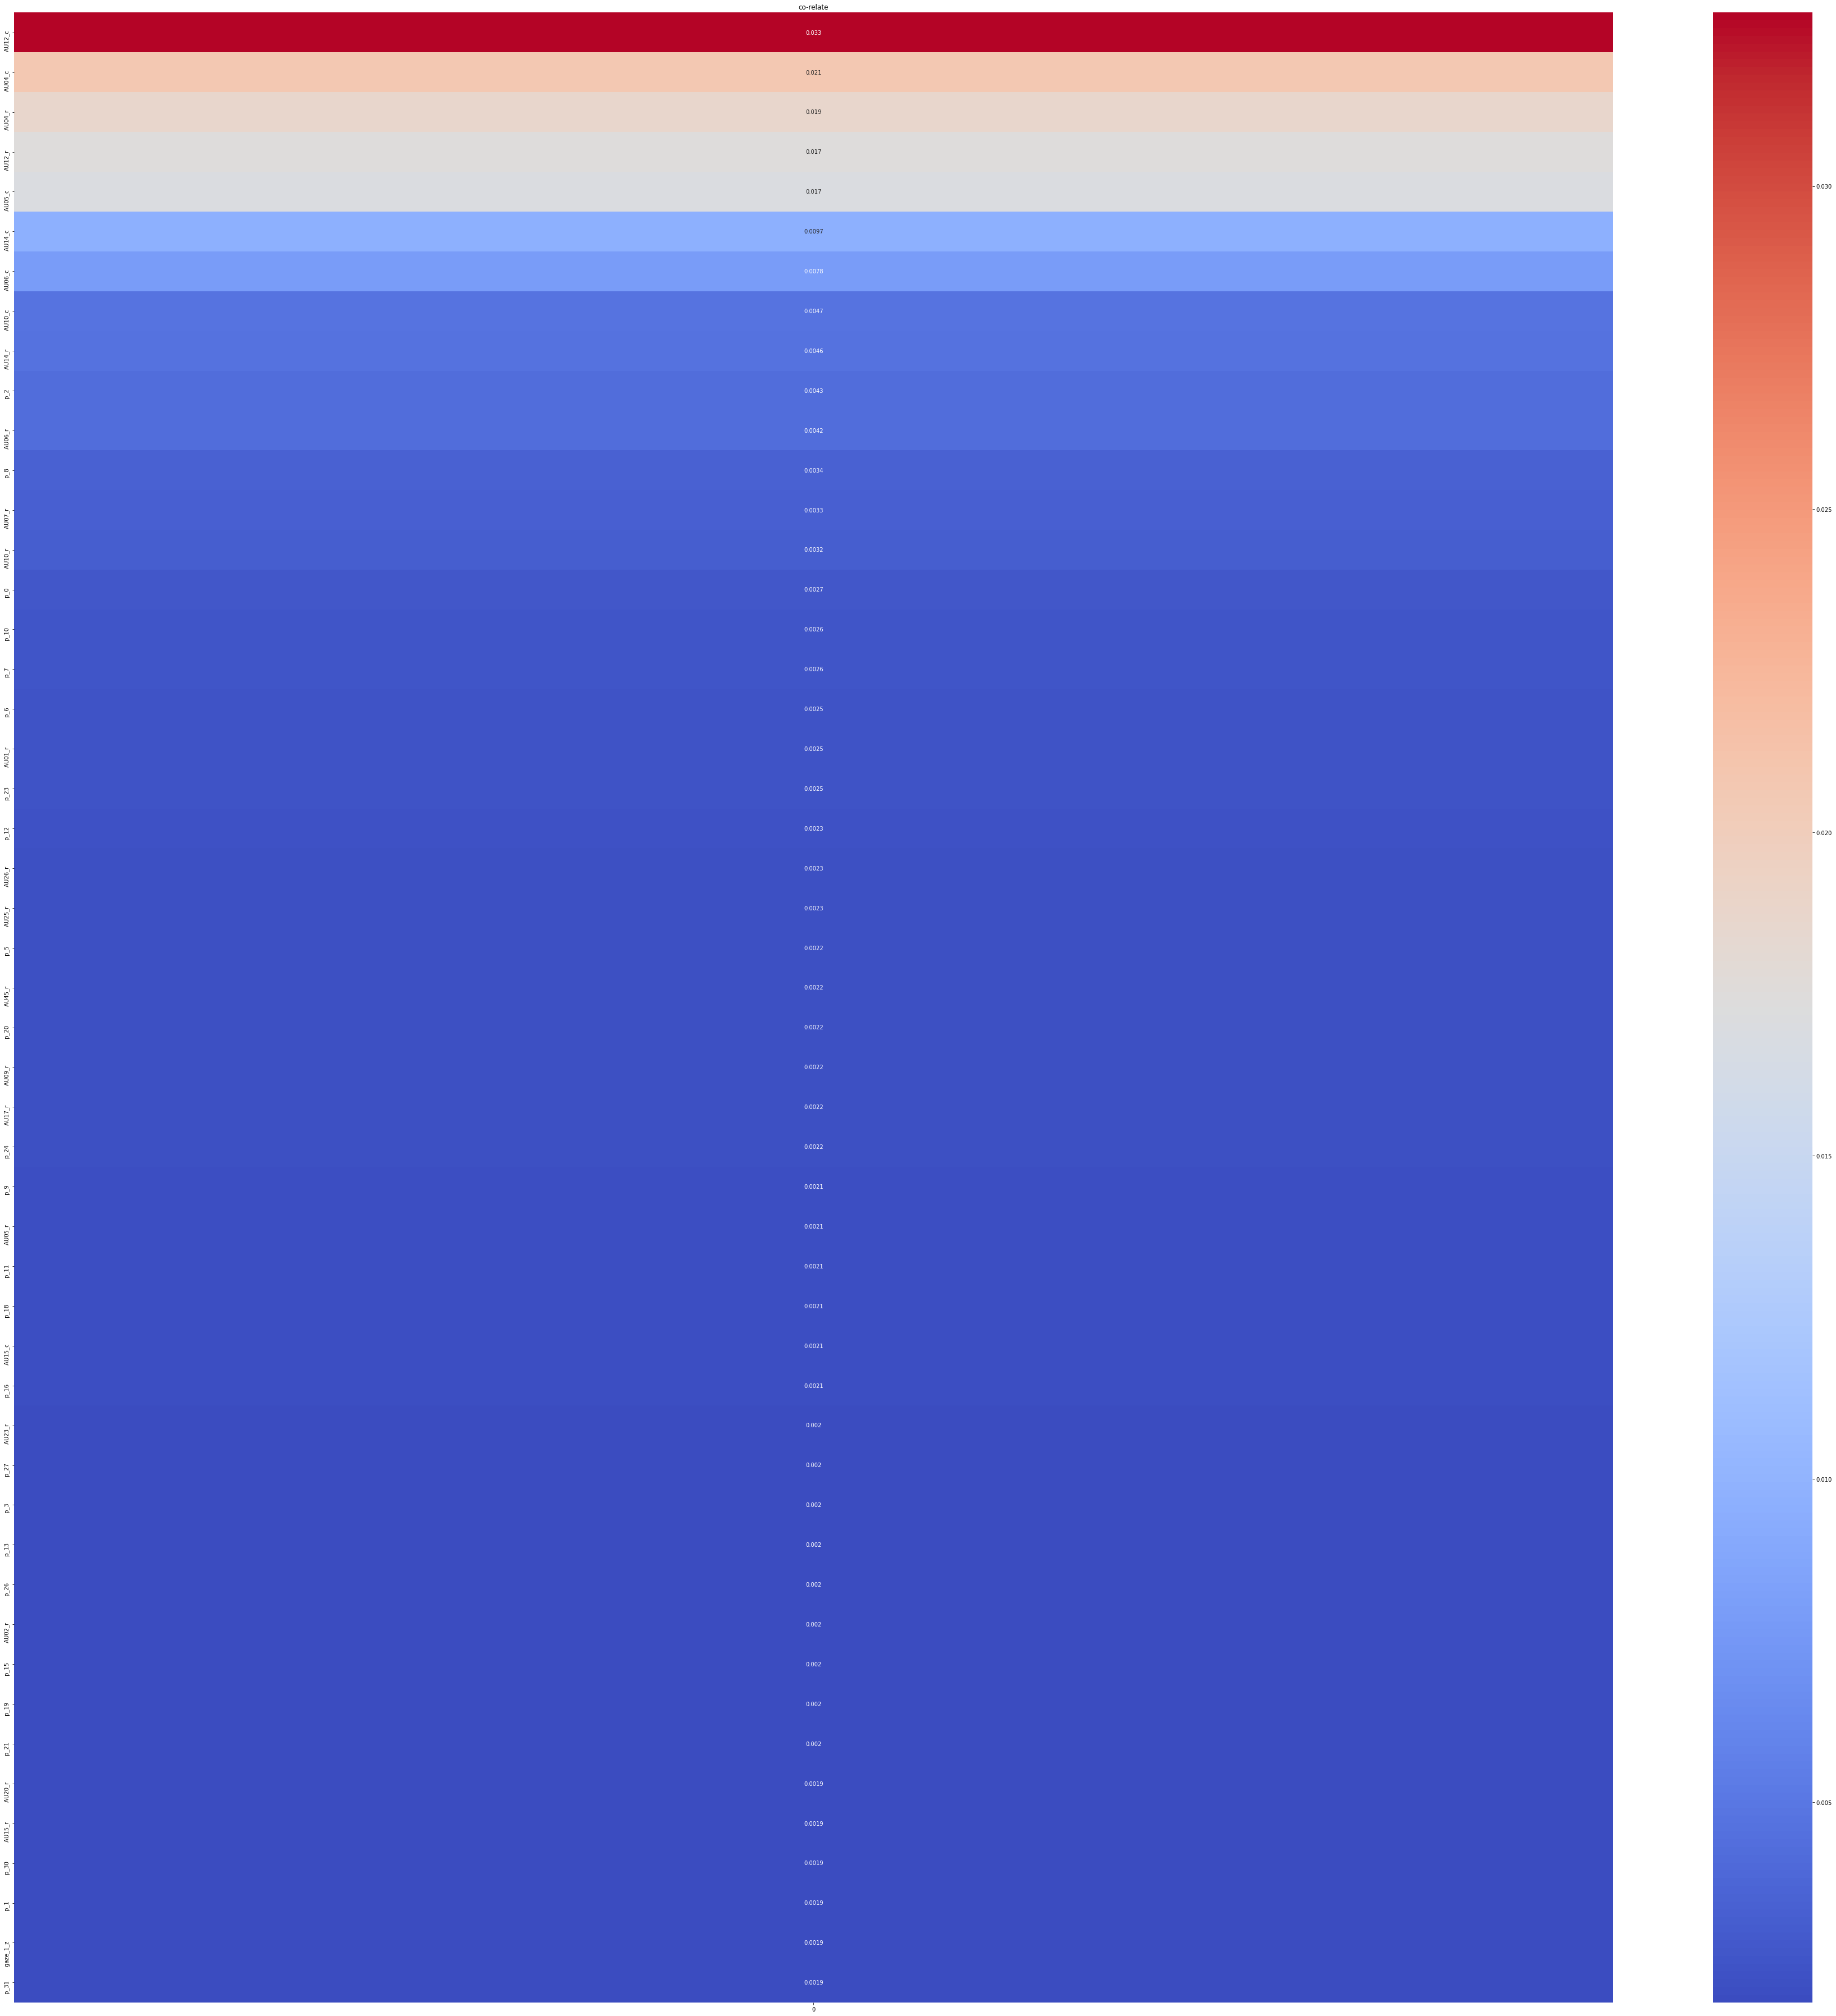

In [15]:
plt.figure(figsize=(50,50))

ax=sns.heatmap(h6, annot=True, cmap="coolwarm", yticklabels=helix['0']).set_title('co-relate')
plt.tight_layout()
plt.show()

<AxesSubplot:>

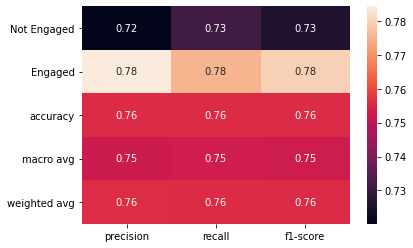

In [16]:
sns.heatmap(pd.DataFrame(claf_report).iloc[:-1, :].T, annot=True)

In [17]:
plt.close()

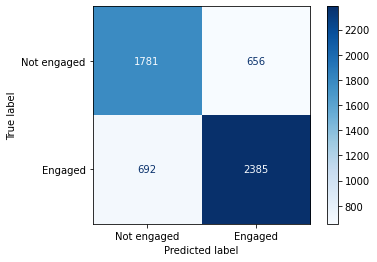

In [18]:
metrics.plot_confusion_matrix(model, X_test, Y_test, cmap=plt.cm.Blues, display_labels=['Not engaged', 'Engaged'])

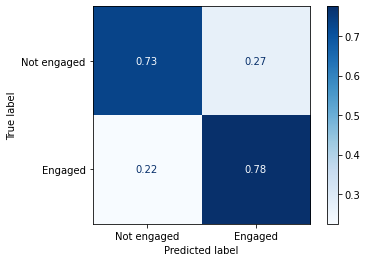

In [19]:
metrics.plot_confusion_matrix(model, X_test, Y_test, cmap=plt.cm.Blues, display_labels=['Not engaged', 'Engaged'], normalize='true')

### Fitting the Model on whole data

In [20]:
model = model.fit(x_train, y_train)

### Saving the Model

In [21]:
patho=r'./models'
joblib.dump(model, (os.path.join(patho,r''+'model_joblib_random_forest')))

['./models/model_joblib_random_forest']